# Bank Marketing - Likelihood of a customer subscribing to a banking product

> The objective of the notebook is to create a machine learning model to predict the likelihood of a customer subscribing to a banking product. The dataset is obtained from [Bank Marketing Data Set](https://archive.ics.uci.edu/ml/datasets/bank+marketing#)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import calendar
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from models.src.data_transformers import (
    RawDataTransformer,
    ModelDataTransfomer,
)
from xgboost import XGBClassifier
from models.src.config import  BANK_MARKETING_MODEL_PICKLE
from sklearn.metrics import (
    classification_report,
    roc_auc_score
)
import joblib

## Load Data

In [2]:
DATA_DIR = os.path.join(os.path.abspath(os.path.dirname('__file__')), '../../data')
df = pd.read_csv(os.path.join(DATA_DIR, 'bank-full.csv'), sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## Data Exploration

> Simple data exploration and quality checks in preparation for building a ML model.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


> We have a mixture of continous and categorical features and have 100% fill rates for all the columns. We also know from the dataset, that some of the columns are binary:
* default
* housing
* loan
* y - target feature

> We will also replace month with the numeric value. The logic for this is encapsulated in [DataFrameTransformer](../src/data_transformers.py) and will be used in a sklearn pipeline to build the model.

In [4]:
dft = RawDataTransformer()
df2 = dft.transform(df)
df2.info()

2019-03-24 12:25:34,191:INFO:Numerising month
2019-03-24 12:25:34,221:INFO:Binarising columns: default
2019-03-24 12:25:34,232:INFO:Binarising columns: housing
2019-03-24 12:25:34,240:INFO:Binarising columns: loan
2019-03-24 12:25:34,250:INFO:Binarising columns: y


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null int64
balance      45211 non-null int64
housing      45211 non-null int64
loan         45211 non-null int64
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null int64
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null int64
dtypes: int64(12), object(5)
memory usage: 5.9+ MB


> `month`, `default`, `housing`, `loan` and `y` are all now numerical features. For categorical features, I will one hot encode them as they are low cardinality.

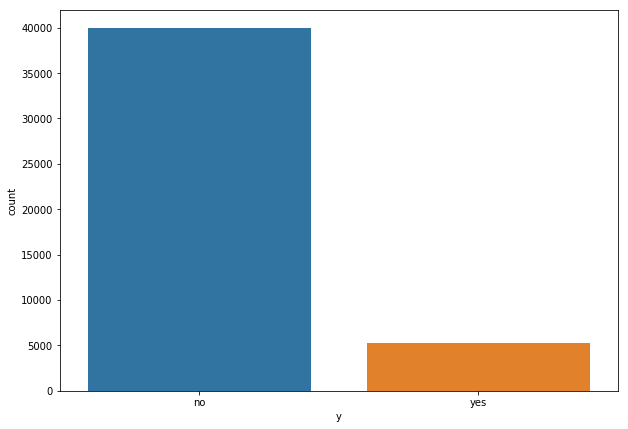

In [5]:
ax = sns.countplot(x='y', data=df)
ax.figure.set_size_inches(10, 7)

> There are many negatives compared to positive targets, indicating imbalanced dataset.

## Model Build

>* ML model using sklearn pipeline and XGBoost
* The parameters are manually tuned
* 70/30 train/test split, stratified on the target feature as it's imbalanced, almost 1:10. Will use `scale_pos_weight` to rebalance the weights according to the target ratios.

In [6]:
TEST_SIZE = 0.3
x_train, x_test, y_train, y_test = train_test_split(
    df.drop('y', axis=1), df2['y'], test_size=TEST_SIZE, random_state=42, stratify=df2['y'], shuffle=True
)

> Random train/test split stratified on the target column because of data imbalance.

In [7]:
pipe = Pipeline([
    ('df_transformer', RawDataTransformer()),
    ('model_transformer', ModelDataTransfomer())
])
pipe = pipe.fit(x_train)
X_train = pipe.transform(x_train)
X_test = pipe.transform(x_test)

2019-03-24 12:25:34,609:INFO:Numerising month
2019-03-24 12:25:34,630:INFO:Binarising columns: default
2019-03-24 12:25:34,641:INFO:Binarising columns: housing
2019-03-24 12:25:34,653:INFO:Binarising columns: loan
2019-03-24 12:25:34,685:INFO:Numerising month
2019-03-24 12:25:34,705:INFO:Binarising columns: default
2019-03-24 12:25:34,712:INFO:Binarising columns: housing
2019-03-24 12:25:34,720:INFO:Binarising columns: loan
2019-03-24 12:25:34,725:INFO:One hot encode categorical features and concat with continuous features.
2019-03-24 12:25:34,783:INFO:Numerising month
2019-03-24 12:25:34,794:INFO:Binarising columns: default
2019-03-24 12:25:34,797:INFO:Binarising columns: housing
2019-03-24 12:25:34,801:INFO:Binarising columns: loan
2019-03-24 12:25:34,805:INFO:One hot encode categorical features and concat with continuous features.


In [8]:
params = {
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'auc'],
    'silent': 0,
    'random_state': 42,
    'n_estimators': 1000,
    'scale_pos_weight': round(1 / y_train.mean()),
}
clf = XGBClassifier(**params)
clf.fit(
    X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=50,
)

[0]	validation_0-logloss:0.660939	validation_0-auc:0.840207	validation_1-logloss:0.66106	validation_1-auc:0.8281
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-logloss:0.634543	validation_0-auc:0.846892	validation_1-logloss:0.634663	validation_1-auc:0.836755
[2]	validation_0-logloss:0.612896	validation_0-auc:0.858683	validation_1-logloss:0.613363	validation_1-auc:0.849118
[3]	validation_0-logloss:0.595176	validation_0-auc:0.859088	validation_1-logloss:0.595451	validation_1-auc:0.850969
[4]	validation_0-logloss:0.579511	validation_0-auc:0.868994	validation_1-logloss:0.579935	validation_1-auc:0.862001
[5]	validation_0-logloss:0.566308	validation_0-auc:0.875866	validation_1-logloss:0.566756	validation_1-auc:0.868173
[6]	validation_0-logloss:0.554049	validation_0-auc:0.878284	validation_1-logloss:0.554885	validation_1-auc:0.870716
[7]	validation_0-logloss:0.544306	

[70]	validation_0-logloss:0.404025	validation_0-auc:0.924518	validation_1-logloss:0.409348	validation_1-auc:0.914692
[71]	validation_0-logloss:0.403539	validation_0-auc:0.924614	validation_1-logloss:0.40884	validation_1-auc:0.914761
[72]	validation_0-logloss:0.402237	validation_0-auc:0.925168	validation_1-logloss:0.407502	validation_1-auc:0.91531
[73]	validation_0-logloss:0.400551	validation_0-auc:0.92594	validation_1-logloss:0.40569	validation_1-auc:0.916126
[74]	validation_0-logloss:0.399796	validation_0-auc:0.926253	validation_1-logloss:0.405156	validation_1-auc:0.916283
[75]	validation_0-logloss:0.398484	validation_0-auc:0.926725	validation_1-logloss:0.40401	validation_1-auc:0.91663
[76]	validation_0-logloss:0.397974	validation_0-auc:0.926933	validation_1-logloss:0.403542	validation_1-auc:0.916829
[77]	validation_0-logloss:0.396892	validation_0-auc:0.927381	validation_1-logloss:0.402478	validation_1-auc:0.91721
[78]	validation_0-logloss:0.395234	validation_0-auc:0.928131	validation

[140]	validation_0-logloss:0.365923	validation_0-auc:0.937988	validation_1-logloss:0.374938	validation_1-auc:0.92519
[141]	validation_0-logloss:0.365649	validation_0-auc:0.938084	validation_1-logloss:0.374657	validation_1-auc:0.925288
[142]	validation_0-logloss:0.365521	validation_0-auc:0.93813	validation_1-logloss:0.37461	validation_1-auc:0.925284
[143]	validation_0-logloss:0.365235	validation_0-auc:0.938253	validation_1-logloss:0.374402	validation_1-auc:0.925275
[144]	validation_0-logloss:0.364657	validation_0-auc:0.938464	validation_1-logloss:0.37378	validation_1-auc:0.925497
[145]	validation_0-logloss:0.36448	validation_0-auc:0.938498	validation_1-logloss:0.373649	validation_1-auc:0.925496
[146]	validation_0-logloss:0.363843	validation_0-auc:0.938745	validation_1-logloss:0.373037	validation_1-auc:0.925747
[147]	validation_0-logloss:0.363546	validation_0-auc:0.93881	validation_1-logloss:0.372954	validation_1-auc:0.925641
[148]	validation_0-logloss:0.363478	validation_0-auc:0.93883	v

[210]	validation_0-logloss:0.34833	validation_0-auc:0.943663	validation_1-logloss:0.361271	validation_1-auc:0.928152
[211]	validation_0-logloss:0.348132	validation_0-auc:0.943724	validation_1-logloss:0.361193	validation_1-auc:0.928182
[212]	validation_0-logloss:0.347539	validation_0-auc:0.94392	validation_1-logloss:0.360596	validation_1-auc:0.928396
[213]	validation_0-logloss:0.347347	validation_0-auc:0.943992	validation_1-logloss:0.360381	validation_1-auc:0.928447
[214]	validation_0-logloss:0.346903	validation_0-auc:0.944119	validation_1-logloss:0.359939	validation_1-auc:0.928574
[215]	validation_0-logloss:0.346667	validation_0-auc:0.944208	validation_1-logloss:0.359867	validation_1-auc:0.928539
[216]	validation_0-logloss:0.34627	validation_0-auc:0.944319	validation_1-logloss:0.359523	validation_1-auc:0.928649
[217]	validation_0-logloss:0.346081	validation_0-auc:0.944382	validation_1-logloss:0.359514	validation_1-auc:0.928582
[218]	validation_0-logloss:0.345763	validation_0-auc:0.9444

[280]	validation_0-logloss:0.334646	validation_0-auc:0.948069	validation_1-logloss:0.35171	validation_1-auc:0.930002
[281]	validation_0-logloss:0.334422	validation_0-auc:0.948135	validation_1-logloss:0.351513	validation_1-auc:0.930068
[282]	validation_0-logloss:0.334198	validation_0-auc:0.948196	validation_1-logloss:0.351296	validation_1-auc:0.930106
[283]	validation_0-logloss:0.334093	validation_0-auc:0.948223	validation_1-logloss:0.351233	validation_1-auc:0.930117
[284]	validation_0-logloss:0.333987	validation_0-auc:0.948241	validation_1-logloss:0.351215	validation_1-auc:0.930093
[285]	validation_0-logloss:0.333823	validation_0-auc:0.948299	validation_1-logloss:0.351092	validation_1-auc:0.930114
[286]	validation_0-logloss:0.333663	validation_0-auc:0.948361	validation_1-logloss:0.351016	validation_1-auc:0.930116
[287]	validation_0-logloss:0.33354	validation_0-auc:0.948408	validation_1-logloss:0.350983	validation_1-auc:0.930061
[288]	validation_0-logloss:0.333447	validation_0-auc:0.948

[350]	validation_0-logloss:0.325848	validation_0-auc:0.950824	validation_1-logloss:0.346313	validation_1-auc:0.93039
[351]	validation_0-logloss:0.325665	validation_0-auc:0.950885	validation_1-logloss:0.346212	validation_1-auc:0.930436
[352]	validation_0-logloss:0.325622	validation_0-auc:0.950899	validation_1-logloss:0.346204	validation_1-auc:0.930428
[353]	validation_0-logloss:0.325491	validation_0-auc:0.950938	validation_1-logloss:0.346136	validation_1-auc:0.930426
[354]	validation_0-logloss:0.325424	validation_0-auc:0.950952	validation_1-logloss:0.346071	validation_1-auc:0.930426
[355]	validation_0-logloss:0.325297	validation_0-auc:0.951002	validation_1-logloss:0.346035	validation_1-auc:0.930421
[356]	validation_0-logloss:0.325279	validation_0-auc:0.951007	validation_1-logloss:0.346035	validation_1-auc:0.930417
[357]	validation_0-logloss:0.325168	validation_0-auc:0.951044	validation_1-logloss:0.345901	validation_1-auc:0.930407
[358]	validation_0-logloss:0.325108	validation_0-auc:0.95

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, eval_metric=['logloss', 'auc'],
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=9.0, seed=None,
       silent=0, subsample=1)

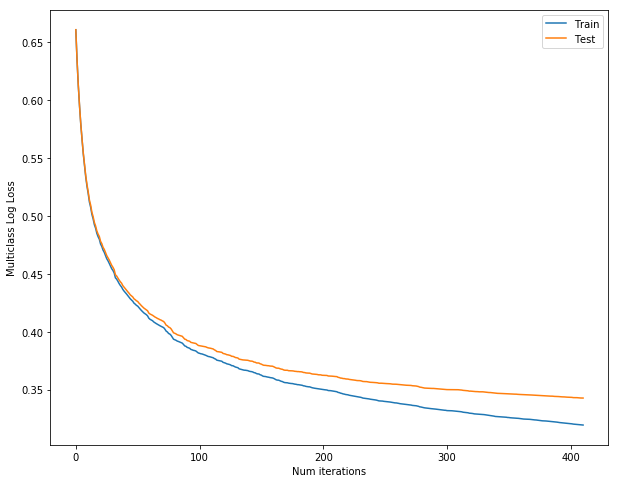

In [9]:
results = clf.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
fig.set_size_inches(10, 8)
ax.set_xlabel('Num iterations');
ax.set_ylabel('Multiclass Log Loss');

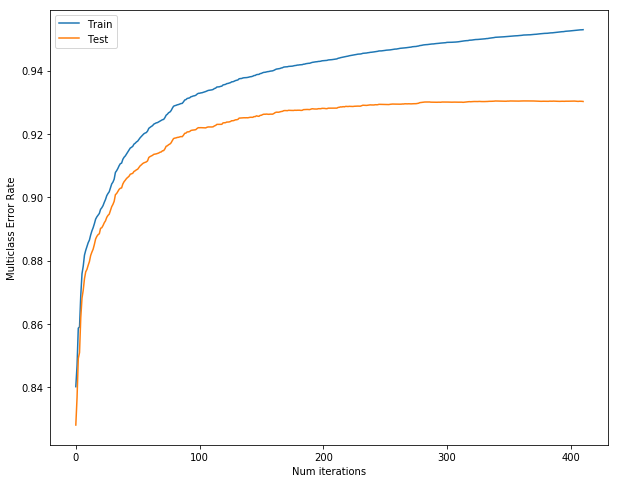

In [10]:
results = clf.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
fig.set_size_inches(10, 8)
ax.set_xlabel('Num iterations')
ax.set_ylabel('Multiclass Error Rate');

In [11]:
print(f'Best iteration: {clf.best_iteration}.')
clf = clf.set_params(n_estimators=clf.best_iteration)

Best iteration: 361.


> Model seems to perform reasonably well, with a AUC of 0.95 for train and 0.93 for test at best iteration of 361.

### Classification Report

In [12]:
print(classification_report(y_train, clf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.99      0.84      0.91     27945
           1       0.44      0.94      0.60      3702

   micro avg       0.85      0.85      0.85     31647
   macro avg       0.72      0.89      0.76     31647
weighted avg       0.93      0.85      0.87     31647



In [13]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.84      0.91     11977
           1       0.42      0.89      0.57      1587

   micro avg       0.85      0.85      0.85     13564
   macro avg       0.70      0.86      0.74     13564
weighted avg       0.92      0.85      0.87     13564



> Train and test metrics are comparable so will use this prototyped model for prediction.

## Final Model

In [14]:
model_pl = Pipeline([
    ('df_transformer', RawDataTransformer()),
    ('model_transformer', ModelDataTransfomer()),
    ('clf', XGBClassifier(**clf.get_params()))
])
model_pl = model_pl.fit(df.drop('y', axis=1), df2['y'])
y_scores = model_pl.predict_proba(df.drop('y', axis=1))[:, 1]
print(f'Overall AUC score: {roc_auc_score(df2["y"], y_scores) * 100: .2f} %')

2019-03-24 12:25:51,619:INFO:Numerising month
2019-03-24 12:25:51,660:INFO:Binarising columns: default
2019-03-24 12:25:51,671:INFO:Binarising columns: housing
2019-03-24 12:25:51,680:INFO:Binarising columns: loan
2019-03-24 12:25:51,715:INFO:One hot encode categorical features and concat with continuous features.
2019-03-24 12:26:03,456:INFO:Numerising month
2019-03-24 12:26:03,495:INFO:Binarising columns: default
2019-03-24 12:26:03,504:INFO:Binarising columns: housing
2019-03-24 12:26:03,516:INFO:Binarising columns: loan
2019-03-24 12:26:03,527:INFO:One hot encode categorical features and concat with continuous features.


Overall AUC score:  94.66 %


In [15]:
joblib.dump(model_pl, BANK_MARKETING_MODEL_PICKLE)
print(f'Saved model to {BANK_MARKETING_MODEL_PICKLE}.')

Saved model to /Users/harsit/work/artificial_ml_challenge/models/src/../models/bank_marketing_model_v1.pkl.


In [16]:
print(f'Finished running notebook: {datetime.datetime.utcnow()}')

Finished running notebook: 2019-03-24 12:26:04.060522
